In [12]:
import os
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import kornia as K
import kornia.feature as KF
import preprocessing
import validation
import plotting

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

input_dir = '../../data/train/' # directory of the training data

In [3]:
# REMOVE LATER
%load_ext autoreload
%autoreload 2

In [ ]:
# for use with MacBooks
# pip install torch

# for use with AMD GPUs on Linux
# pip3 install torch --extra-index-url https://download.pytorch.org/whl/rocm5.1.1

In [4]:
# Load all scene names from the training data
all_scenes = preprocessing.get_scenes(input_dir)
all_scenes 

['brandenburg_gate',
 'british_museum',
 'buckingham_palace',
 'colosseum_exterior',
 'grand_place_brussels',
 'lincoln_memorial_statue',
 'notre_dame_front_facade',
 'pantheon_exterior',
 'piazza_san_marco',
 'sacre_coeur',
 'sagrada_familia',
 'st_pauls_cathedral',
 'st_peters_square',
 'taj_mahal',
 'temple_nara_japan',
 'trevi_fountain']

In [5]:
# Load all image pairs, along with their covisibility and fundamental matrix

#scenes = all_scenes # load all scenes
scenes = [all_scenes[0]] # load only the first scene

pairs = preprocessing.load_pairs(scenes,input_dir)

# Load either all pairs, or only withing a specific covisibility range
pairs = pairs.reset_index()
#pairs = pairs.query('covisibility > 0.95').reset_index()
#pairs = pairs.query('0.7 < covisibility < 0.8').reset_index()

pairs

loading category 1 of 1: brandenburg_gate


,index,pair,covisibility,fundamental_matrix,scene
0,0,90920828_5082887495-20133057_3035445116,0.905,-9.27158516e-04 1.22034601e-01 -9.87725452e+01...,brandenburg_gate
1,1,90920828_5082887495-17262282_1141017004,0.936,1.68899800e-03 1.18269247e-01 -1.02939518e+02 ...,brandenburg_gate
2,2,20133057_3035445116-17262282_1141017004,0.908,-5.56308440e-04 1.74170978e-02 -2.49391042e+01...,brandenburg_gate
3,3,38600512_2168650655-17262282_1141017004,0.901,1.26837683e-02 -5.42924979e-01 4.29820975e+02 ...,brandenburg_gate
4,4,60770994_853214983-17262282_1141017004,0.912,-1.05214974e-02 -4.87393290e-01 3.90468870e+02...,brandenburg_gate
...,...,...,...,...,...
61070,61070,67494650_6905234882-63229395_2704362565,0.019,-1.83952792e-02 1.11447290e-01 -8.55666688e+01...,brandenburg_gate
61071,61071,67494650_6905234882-65128211_1900926684,0.037,-3.19883341e-02 5.26823598e-01 -3.14236536e+02...,brandenburg_gate
61072,61072,67494650_6905234882-65235481_5082884383,0.095,-1.39080165e-02 7.79098666e-01 -4.67854880e+02...,brandenburg_gate
61073,61073,67494650_6905234882-67080033_7235561554,0.000,9.69361910e-02 -1.65968509e+00 9.28898161e+02 ...,brandenburg_gate


In [6]:
# Determine if a GPU is available, otherwise use CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [7]:
# Initialize LoFTR and load the outdoor weights
matcher = KF.LoFTR(pretrained='outdoor')
matcher = matcher.to(device).eval()

In [103]:
# Run LoFTR on the image pairs loaded previously. The output is a DataFrame containing all relevant data for each image pair analyzed.
scene_list = []
fund_matrix_list = []
pair_list = []
fund_matrix_eval = []
pair_eval = []
mkpts0_list = []
mkpts1_list = []
mconf_list = []

for index, row in pairs.head(3).iterrows(): # Head controls how many image pairs are analyzed
    
    split_pair = pairs.pair[index].split('-')
    img_id0 = split_pair[0]
    img_id1 = split_pair[1]
    
    img0_pth = os.path.join(input_dir, pairs.scene[index], "images", str(img_id0 + '.jpg'))
    img1_pth = os.path.join(input_dir, pairs.scene[index], "images", str(img_id1 + '.jpg'))
    img0 = preprocessing.load_torch_image(img0_pth, device)
    img1 = preprocessing.load_torch_image(img1_pth, device)
    batch = {"image0": K.color.rgb_to_grayscale(img0), 
            "image1": K.color.rgb_to_grayscale(img1)}
    
    with torch.no_grad():
        matcher(batch)
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        mconf = batch['mconf'].cpu().numpy()
        
    F = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.2, 0.99999, 50000)
    
    scene_list.append(pairs.scene[index])
    fund_matrix_list.append(F[0])
    pair_list.append(pairs.pair[index])
    fund_matrix_eval.append(" ".join(str(num) for num in F[0].flatten().tolist()))
    pair_eval.append(";".join(["phototourism",pairs.scene[index],pairs.pair[index]]))
    mkpts0_list.append(mkpts0)
    mkpts1_list.append(mkpts1)
    mconf_list.append(mconf)
    
results = pd.DataFrame({'scene': scene_list, 'pair': pair_list, 'fund_matrix': fund_matrix_list, 
                        'mkpts0': mkpts0_list, 'mkpts1': mkpts1_list, 'mconf': mconf_list,
                        'pair_eval': pair_eval, 'fund_matrix_eval': fund_matrix_eval}) 

In [104]:
results

,scene,pair,fund_matrix,mkpts0,mkpts1,mconf,pair_eval,fund_matrix_eval
0,brandenburg_gate,90920828_5082887495-20133057_3035445116,"[[2.1126528774146934e-11, -6.418289745130975e-...","[[390.13922, 15.92405], [398.10126, 15.92405],...","[[398.10156, 31.996542], [406.06366, 32.018314...","[0.6438327, 0.69639623, 0.54881716, 0.56197387...",phototourism;brandenburg_gate;90920828_5082887...,2.1126528774146934e-11 -6.418289745130975e-07 ...
1,brandenburg_gate,90920828_5082887495-17262282_1141017004,"[[1.5869265645526104e-07, 2.044659307674642e-0...","[[421.98734, 15.92405], [429.94937, 15.92405],...","[[453.82855, 14.495544], [462.6294, 15.441739]...","[0.5752913, 0.30813524, 0.32299042, 0.29086754...",phototourism;brandenburg_gate;90920828_5082887...,1.5869265645526104e-07 2.044659307674642e-06 -...
2,brandenburg_gate,20133057_3035445116-17262282_1141017004,"[[1.6019301112698599e-07, 1.6066317068103543e-...","[[406.69232, 31.897436], [414.66666, 31.897436...","[[431.26605, 14.213745], [438.86636, 14.478426...","[0.21635596, 0.49584776, 0.92422485, 0.6352027...",phototourism;brandenburg_gate;20133057_3035445...,1.6019301112698599e-07 1.6066317068103543e-06 ...


In [105]:
# Run the validation on all results and return the mean average accuracy
maa = validation.evaluate(input_dir, results.pair_eval, results.fund_matrix_eval)
print(f'mAA={maa} (n={len(results)})')

mAA=0.3333333333333333 (n=3)


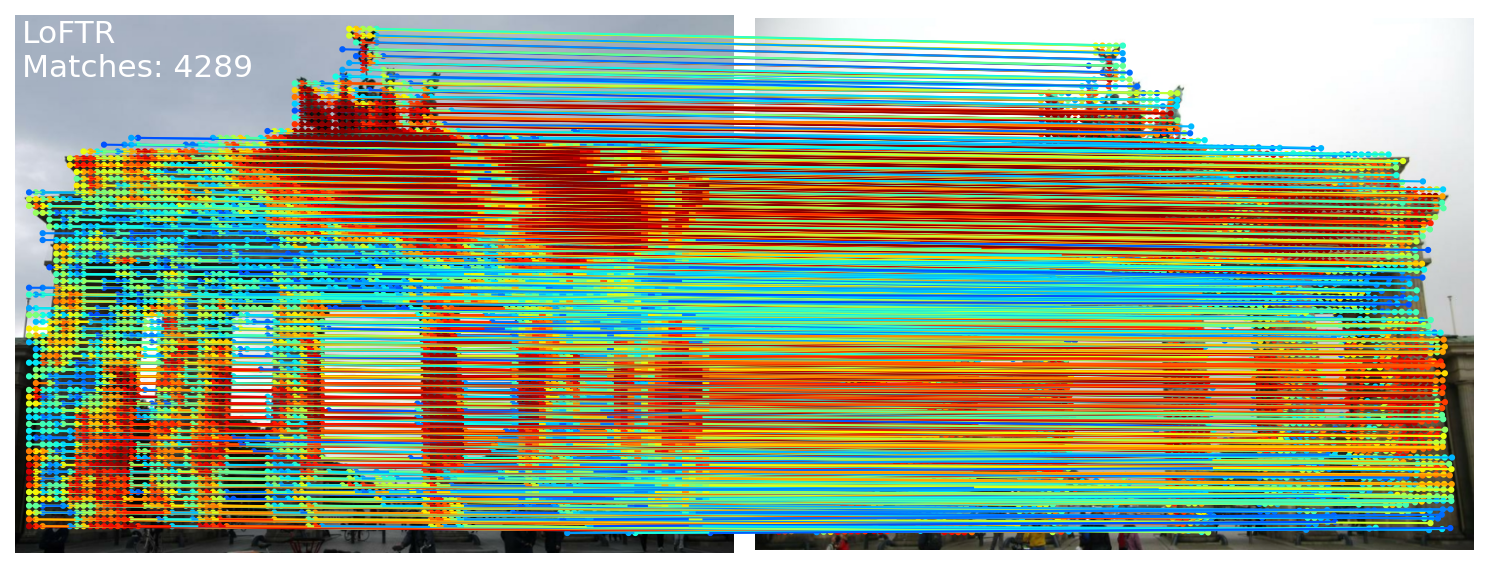

In [109]:
# Draw matches for a single pair from the results

index = 0 # select image pair from results DataFrame
threshold = 0 # setting a confidence threshold (0 == no threshold)

df_draw = pd.DataFrame({'mkpts0': results.mkpts0[index].tolist(), 'mkpts1': results.mkpts1[index].tolist(), 'mconf': results.mconf[index].tolist()})

img0_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[0] + '.jpg'))
img1_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[1] + '.jpg'))
img0 = preprocessing.load_image(img0_pth)
img1 = preprocessing.load_image(img1_pth)

color = cm.jet(df_draw.query(f'mconf > {threshold}').mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(df_draw.query(f'mconf > {threshold}')))]
fig = plotting.make_matching_figure(img0, img1, np.array(df_draw.query(f'mconf > {threshold}').mkpts0.values.tolist()), 
                                    np.array(df_draw.query(f'mconf > {threshold}').mkpts1.values.tolist()), color, text=text, dpi=150, alpha = 1, lines = True)

In [107]:
import LoFTR_plotly as LP

In [111]:
fig = LP.single_loftr_figure(img0_pth, img1_pth)

In [112]:
fig

(                                        mkpts0  \
 0     [390.13922119140625, 15.924050331115723]   
 1     [398.10125732421875, 15.924050331115723]   
 2     [406.06329345703125, 15.924050331115723]   
 3      [414.0252990722656, 15.924050331115723]   
 4      [421.9873352050781, 15.924050331115723]   
 ...                                        ...   
 4284      [804.16455078125, 597.1519165039062]   
 4285    [644.9240112304688, 605.1138916015625]   
 4286     [716.582275390625, 605.1138916015625]   
 4287    [724.5443115234375, 605.1138916015625]   
 4288    [812.1265869140625, 605.1138916015625]   
 
                                         mkpts1     mconf  
 0             [398.1015625, 31.99654197692871]  0.643833  
 1     [406.06365966796875, 32.018314361572266]  0.696396  
 2      [414.0255432128906, 32.295936584472656]  0.548817  
 3      [421.9873352050781, 32.019859313964844]  0.561974  
 4     [429.94903564453125, 32.037296295166016]  0.407604  
 ...                      

In [ ]:
# Draw matches for a single pair from the results

index = 7 # select image pair from results DataFrame
threshold = 0 # setting a confidence threshold (0 == no threshold)

df_draw = pd.DataFrame({'mkpts0': results.mkpts0[index].tolist(), 'mkpts1': results.mkpts1[index].tolist(), 'mconf': results.mconf[index].tolist()})

img0_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[0] + '.jpg'))
img1_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[1] + '.jpg'))
img0 = load_image(img0_pth)
img1 = load_image(img1_pth)

color = cm.jet(df_draw.query(f'mconf > {threshold}').mconf)
color_trans = color * np.full(color.shape,255)
color_trans = np.delete(color_trans, -1, axis=1)
color_plotly = [f'rgb({",".join(c)})' for c in color_trans.astype(str)]
text = [
    'LoFTR',
    'Matches: {}'.format(len(df_draw.query(f'mconf > {threshold}')))]
fig = plotting.make_matching_figure_plotly(img0, img1, np.array(df_draw.query(f'mconf > {threshold}').mkpts0.values.tolist()), 
                                    np.array(df_draw.query(f'mconf > {threshold}').mkpts1.values.tolist()), color_plotly, text=text, alpha = 0.1)
fig

In [ ]:
F = cv2.findFundamentalMat(np.array(df_draw.query(f'mconf > {threshold}').mkpts0.values.tolist()), np.array(df_draw.query(f'mconf > {threshold}').mkpts1.values.tolist()), cv2.USAC_MAGSAC, 0.2, 0.99999, 50000)
single_evaluate_scene = results.scene[index]
single_evaluate_pair = results.pair[index]
single_evaluate_pair_eval = results.pair_eval[index]
aa = validation.evaluate_single(input_dir, single_evaluate_pair_eval, " ".join(str(num) for num in F[0].flatten().tolist()))
print(f'Accuracy = {aa[0]}\nAngle error (degrees) = {aa[1][single_evaluate_scene][single_evaluate_pair]}\nDistance error (meters) = {aa[2][single_evaluate_scene][single_evaluate_pair]}')

In [ ]:
from sklearn.cluster import DBSCAN
X = results.mkpts0[7]
Y = results.mkpts1[7]

In [ ]:
plt.scatter(X[:, 0], X[:, 1])

In [ ]:
plt.scatter(Y[:, 0], Y[:, 1])

In [ ]:
clustering = DBSCAN(eps=20, min_samples=5).fit(X)
plt.scatter(X[:, 0], X[:, 1], c = clustering.labels_)